In [17]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras 

from keras import layers
from sklearn.model_selection import train_test_split

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
train_numerical = pd.read_pickle("processed_data/GLC24_PA_metadata_train_elevation_onehot_grouped.pkl")
print(train_numerical.columns)
if "speciesId" in train_numerical.columns:
    train_numerical = train_numerical.drop(columns=["speciesId"], axis=0)
cols = train_numerical.columns
train_numerical = train_numerical.to_numpy()


Index([      'lon',       'lat',      'year',  'areaInM2', 'speciesId',
       'elevation',    'ALPINE',  'ATLANTIC', 'BLACK SEA',    'BOREAL',
       ...
             11239,       11240,       11241,       11242,       11243,
             11245,       11246,       11248,       11253,       11254],
      dtype='object', length=5059)


In [9]:
print(train_numerical.shape)
print(cols[:42])

(88987, 5058)
Index(['lon', 'lat', 'year', 'areaInM2', 'elevation', 'ALPINE', 'ATLANTIC',
       'BLACK SEA', 'BOREAL', 'CONTINENTAL', 'MEDITERRANEAN', 'PANNONIAN',
       'STEPPIC', 'Andorra', 'Austria', 'Belgium', 'Bosnia and Herzegovina',
       'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'France', 'Germany',
       'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Luxembourg',
       'Monaco', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland',
       'The former Yugoslav Republic of Macedonia'],
      dtype='object')


In [10]:
xx = train_numerical[:, :42]
yy = train_numerical[:, 42:]
train_numerical = None          # No longer needed, send to garbage collector to save memory

In [11]:
img = np.load("processed_images/train_rgbnir.npz", allow_pickle=True)["arr_0"]

In [12]:
X_train_table, X_val_table, X_train_image, X_val_image, y_train, y_val = train_test_split(xx, img, yy, test_size=0.2, shuffle=True, random_state=113)

img = None 
xx = None 
yy = None

In [13]:
print(X_train_table.shape)
print(X_val_table.shape)
print(X_train_image.shape)
print(X_val_image.shape)
print(y_train.shape)
print(y_val.shape)

(71189, 42)
(17798, 42)
(71189, 128, 128, 6)
(17798, 128, 128, 6)
(71189, 5016)
(17798, 5016)


In [14]:
table_in = keras.Input(shape=(42,))
table_dense = layers.Dense(64)(table_in)

image_in = keras.Input(shape=(128, 128, 6))
image_dense = layers.Dense(64)(image_in)
image_conv = layers.Conv2D(64, (3, 3))(image_dense)
image_flat = layers.Flatten()(image_conv)

combination = layers.Concatenate()([table_dense, image_flat])
output = layers.Dense(64)(combination)

model = keras.Model(inputs=[table_in, image_in], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 6)]        0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 128, 128, 64)         448       ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 64)         36928     ['dense_1[0][0]']             
                                                                                              

2024-04-08 18:02:03.544000: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 18:02:03.687471: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 18:02:03.687686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [15]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [18]:
model.fit(x=[X_train_table, X_train_image], y=y_train, validation_data=([X_val_table, X_val_image], y_val), epochs=10, batch_size=32)

: 

In [1]:
from preprocessor import Preprocessor, ImagePreprocessor

pp = Preprocessor()

In [2]:
data = pp.preprocess()
data.head(10)

/home/tim/Documents/Projects/ml-geolife/preprocessor.py:105: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("use_inf_as_na", True):
/home/tim/Documents/Projects/ml-geolife/preprocessor.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.data[
/home/tim/Documents/Projects/ml-geolife/preprocessor.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.data[
/home/tim/Documents/Projects/ml-geolife/preproc

,lon,lat,year,areaInM2,ALPINE,ATLANTIC,BLACK SEA,BOREAL,CONTINENTAL,MEDITERRANEAN,...,11005,11054,11078,11120,11140,11157,11188,11193,11195,elevation
surveyId,,,,,,,,,,,,,,,,,,,,,
212,3.099038,43.134956,2021,100.0,False,False,False,False,False,True,...,False,False,False,False,False,True,False,True,False,26
222,9.884560,56.912140,2017,79.0,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,54
243,8.256020,55.637050,2019,79.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,-2
324,-0.402590,43.505630,2018,79.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,194
333,-0.517360,45.806430,2017,79.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,54
391,6.396106,52.772240,2017,105.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,-2
410,5.614480,47.217590,2019,79.0,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,250
489,12.449910,47.011700,2018,79.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1874
590,5.028387,51.601834,2017,4.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,-2


In [3]:
data.shape

(87926, 513)

In [4]:
ip = ImagePreprocessor(train_ids=data.index.to_list())
images = ip.preprocess()[0]

In [5]:
images.shape

(87926, 128, 128, 4)

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

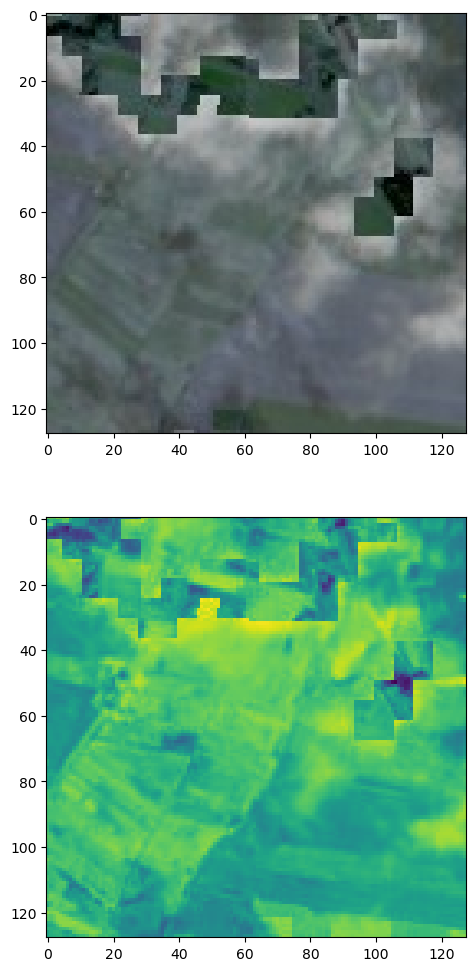

In [10]:
f, ax = plt.subplots(2, 1, figsize=(6, 12))

idx = 1
# temp_image = np.transpose(images, axes=[0, 3,  1, 2]) 
# temp_image[0, 3, :, :] = 1
# temp_image = np.transpose(temp_image, axes=[0, 2, 3, 1])

ax[0].imshow(images[idx,:, :, :3])
ax[1].imshow(images[idx,:, :, 3:])

plt.show()

In [8]:
import numpy as np

In [9]:
temp_image = np.transpose(images, axes=[0, 3,  1, 2]) 
temp_image.shape

(87926, 4, 128, 128)